# Transfer learning for computer vision

In [1]:
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion() # interactive mode

In [3]:
# load data
# data augmentation and normalization for training
# just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

data_dir = 'data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                     for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4)
                      for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')

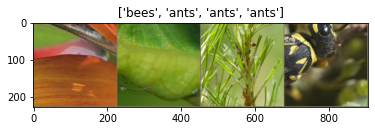

In [4]:
# visualize a few images
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1,2,0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

# get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

In [5]:
# training the model
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-'*10)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            running_loss = 0.0
            running_corrects = 0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # zero parameter gradients
                optimizer.zero_grad()
                
                # forward and track history only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()
    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed//60, time_elapsed%60))
    print('Best vel Acc: {:.4f}'.format(best_acc))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [13]:
# visualize the model predictions
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])
                
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
            model.train(mode=was_training)

In [8]:
# finetuning the convnet
# load a pretrained model and reset final fully connected layer
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\Bekhnam/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [9]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------


C:\Users\Bekhnam\anaconda3\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


train Loss: 0.6518 Acc: 0.6885
val Loss: 0.2284 Acc: 0.9346

Epoch 1/24
----------
train Loss: 0.5297 Acc: 0.7828
val Loss: 0.4532 Acc: 0.8431

Epoch 2/24
----------
train Loss: 0.4556 Acc: 0.7992
val Loss: 0.2239 Acc: 0.9412

Epoch 3/24
----------
train Loss: 0.3155 Acc: 0.8648
val Loss: 0.2999 Acc: 0.8954

Epoch 4/24
----------
train Loss: 0.5892 Acc: 0.8033
val Loss: 0.2731 Acc: 0.8889

Epoch 5/24
----------
train Loss: 0.4490 Acc: 0.8238
val Loss: 0.2345 Acc: 0.8954

Epoch 6/24
----------
train Loss: 0.5657 Acc: 0.8033
val Loss: 0.3296 Acc: 0.9085

Epoch 7/24
----------
train Loss: 0.4212 Acc: 0.8443
val Loss: 0.2639 Acc: 0.9281

Epoch 8/24
----------
train Loss: 0.3194 Acc: 0.8770
val Loss: 0.2403 Acc: 0.9150

Epoch 9/24
----------
train Loss: 0.3337 Acc: 0.8730
val Loss: 0.2359 Acc: 0.9216

Epoch 10/24
----------
train Loss: 0.3267 Acc: 0.8566
val Loss: 0.2228 Acc: 0.9412

Epoch 11/24
----------
train Loss: 0.3129 Acc: 0.8648
val Loss: 0.2421 Acc: 0.9346

Epoch 12/24
----------
t

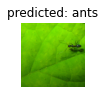

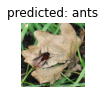

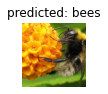

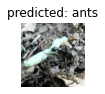

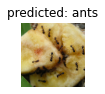

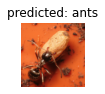

In [14]:
visualize_model(model_ft)

In [15]:
# ConvNet as fixed feature extractor
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [16]:
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5842 Acc: 0.6926
val Loss: 0.2645 Acc: 0.8954

Epoch 1/24
----------
train Loss: 0.3714 Acc: 0.8279
val Loss: 0.1906 Acc: 0.9346

Epoch 2/24
----------
train Loss: 0.4419 Acc: 0.7910
val Loss: 0.2347 Acc: 0.9216

Epoch 3/24
----------
train Loss: 0.5782 Acc: 0.7254
val Loss: 0.2454 Acc: 0.9020

Epoch 4/24
----------
train Loss: 0.4311 Acc: 0.8156
val Loss: 0.1778 Acc: 0.9346

Epoch 5/24
----------
train Loss: 0.3942 Acc: 0.8074
val Loss: 0.1946 Acc: 0.9412

Epoch 6/24
----------
train Loss: 0.4463 Acc: 0.8320
val Loss: 0.1837 Acc: 0.9346

Epoch 7/24
----------
train Loss: 0.5712 Acc: 0.7336
val Loss: 0.1903 Acc: 0.9346

Epoch 8/24
----------
train Loss: 0.5497 Acc: 0.7500
val Loss: 0.2533 Acc: 0.9020

Epoch 9/24
----------
train Loss: 0.4366 Acc: 0.8156
val Loss: 0.1720 Acc: 0.9542

Epoch 10/24
----------
train Loss: 0.5367 Acc: 0.7459
val Loss: 0.2031 Acc: 0.9412

Epoch 11/24
----------
train Loss: 0.3987 Acc: 0.8320
val Loss: 0.2416 Acc: 0.9150

Ep

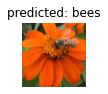

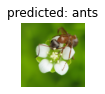

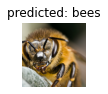

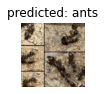

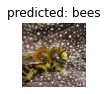

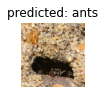

In [17]:
visualize_model(model_conv)
plt.ioff()
plt.show()